# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 7: $k$-NN Classification and Imputation

**Harvard University**<br>
**Fall 2019**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras.  <br>
**Contributors:** Kevin Rader

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals 
In this lab, we'll explore classification models to predict the health status of survey respondents and be able to build a classification decision boundary to predict the resultsing unbalanced classes.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - $k$-NN Regression
 - ROC curves and classification metrics
- Be able to optimize some loss function based on misclassification rates
- Be able to impute for missing values
- Be comfortable in the different approaches in handling missingness

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# %matplotlib inline
import seaborn as sns

## Part 1:  General Social Survey Data + EDA

The dataset contains a subset of data from the General Social Survey (GSS) that is a bi-annual survey of roughly 2000 Americans.  We will be using a small subset of the approx 4000 questions they ask.  Specifically we'll use:  

- **id:** respondant's unique ID
- **health:** self-reported health level with 4 categories: poor, fair, good, excellent
- **partyid:** political party affiliation with categories dem, rep, or other
- **age:** age in years
- **sex:** male or female
- **sexornt:** sexual orientation with categories hetero, gay, or bisexual/other
- **educ:** number of years of formal education (capped at 20 years)
- **marital:** marital status with categories married, never married, and no longer married
- **race:** with categories black, white, and other
- **income:** in thousands of dollars

Our goal is to predict whether or not someone is in **poor health** based on the other measures.

For this task, we will exercise our normal data science pipeline -- from EDA to modeling and visualization. In particular, we will show the performance of 2 classifiers:

- Logistic Regression
- $k$-NN Regression

So without further ado...

### EDA

Do the following basic EDA (always good ideas):
1. Determine the dimensions of the data set.
2. Get a glimpse of the data set.
3. Calculate basic summary/descriptive statistics of the variables.

We also ask that you do the following:
4. Create a binary called `poorhealth`.  
5. Explore the distribution of the responses, `health` and `poorhealth`, 
6. Explore what variables may be related to whether or not some is of poor health.  

In [4]:
gssdata = pd.read_csv("../data/gsshealth18.csv")

#####
# You code here: EDA
# 1. Determine the dimensions of the data set.
# 2. Get a glimpse of the data set.
# 3. Calculate basic summary/descriptive statistics of the variables.
####
gssdata.head()

,id,health,partyid,age,sex,sexornt,educ,marital,race,income
0,1,good,rep,43.0,male,bisexual/other,14.0,never married,white,NaN
1,2,excellent,dem,74.0,female,hetero,10.0,no longer married,white,NaN
2,5,excellent,rep,71.0,male,hetero,18.0,no longer married,black,NaN
3,6,good,dem,67.0,female,bisexual/other,16.0,no longer married,white,NaN
4,7,good,dem,59.0,female,bisexual/other,13.0,no longer married,black,18.75


In [6]:
print(gssdata.shape)
print(gssdata.info())
gssdata.describe()

(1569, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 10 columns):
id         1569 non-null int64
health     1569 non-null object
partyid    1569 non-null object
age        1567 non-null float64
sex        1569 non-null object
sexornt    1569 non-null object
educ       1567 non-null float64
marital    1567 non-null object
race       1569 non-null object
income     908 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 122.7+ KB
None


,id,age,educ,income
count,1569.000000,1567.000000,1567.000000,908.000000
mean,1182.409815,48.135290,13.785578,49.367566
std,675.573679,18.234273,2.933485,45.127528
min,1.000000,18.000000,0.000000,0.500000
25%,601.000000,33.000000,12.000000,18.750000
50%,1188.000000,46.000000,14.000000,37.500000
75%,1769.000000,62.000000,16.000000,67.500000
max,2348.000000,89.000000,20.000000,200.000000


In [7]:
gssdata.health.value_counts()

good         771
excellent    359
fair         355
poor          84
Name: health, dtype: int64

In [8]:
gssdata['poorhealth'] = gssdata['health'].map(lambda x: 1 if x=='poor' else 0)
gssdata['poorhealth'].value_counts()

0    1485
1      84
Name: poorhealth, dtype: int64

<AxesSubplot:xlabel='income', ylabel='Count'>

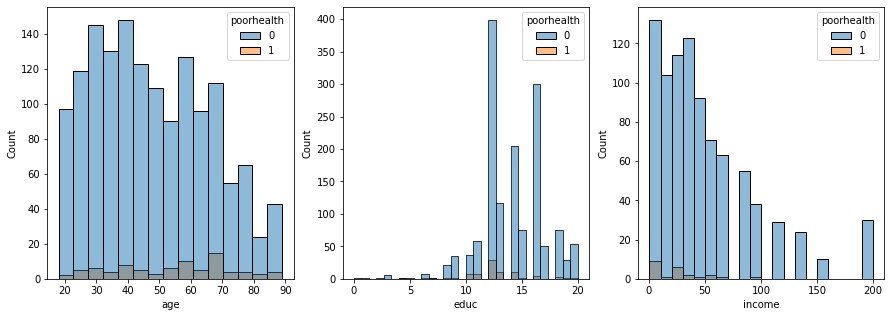

In [10]:
# lets plot the spread of quantitative predictors
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=gssdata, x='age', hue='poorhealth', ax=ax[0])
sns.histplot(data=gssdata, x='educ', hue='poorhealth', ax=ax[1])
sns.histplot(data=gssdata, x='income', hue='poorhealth', ax=ax[2])

In [12]:
# what are ages and income of people with poorhealth
ph_df = gssdata.query('poorhealth == 1')
ph_df.describe()

,id,age,educ,income,poorhealth
count,84.000000,84.000000,84.000000,23.000000,84.0
mean,1257.285714,54.738095,12.333333,24.815217,1.0
std,654.994483,18.309994,2.617519,25.516730,0.0
min,13.000000,19.000000,4.000000,0.500000,1.0
25%,767.250000,39.000000,11.000000,3.500000,1.0
50%,1217.500000,56.500000,12.000000,21.250000,1.0
75%,1822.750000,69.000000,13.250000,32.500000,1.0
max,2309.000000,89.000000,20.000000,100.000000,1.0


In [14]:
# do young people (age <= 30) with low income have poor health?
young_ph_df = gssdata.query('(poorhealth == 1) & (age <= 30)')
young_ph_df.describe()

,id,age,educ,income,poorhealth
count,11.000000,11.000000,11.000000,4.00000,11.0
mean,1414.454545,25.545455,12.272727,9.06250,1.0
std,475.314078,3.503245,1.489356,8.43696,0.0
min,601.000000,19.000000,10.000000,2.00000,1.0
25%,1103.000000,23.500000,11.500000,4.62500,1.0
50%,1409.000000,25.000000,12.000000,6.50000,1.0
75%,1847.000000,28.500000,13.500000,10.93750,1.0
max,2061.000000,30.000000,14.000000,21.25000,1.0


<AxesSubplot:>

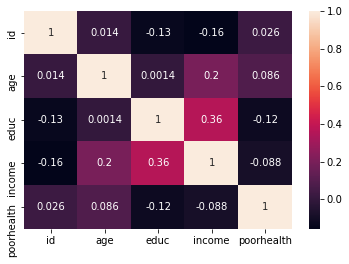

In [15]:
# age seems to be the primary predictor for health, followed by income?
sns.heatmap(gssdata.corr(), annot=True)

In [5]:
gssdata.isna().sum()

id           0
health       0
partyid      0
age          2
sex          0
sexornt      0
educ         2
marital      2
race         0
income     661
dtype: int64

In [16]:
I_test = gssdata[gssdata['marital'].isna()]
I_test

,id,health,partyid,age,sex,sexornt,educ,marital,race,income,poorhealth
25,40,good,other,50.0,female,bisexual/other,12.0,NaN,black,NaN,0
1478,2222,fair,other,65.0,male,bisexual/other,19.0,NaN,white,NaN,0


In [17]:
y_test = I_test['marital']
I_test = I_test.drop(columns=['marital'])

In [18]:
I_test

,id,health,partyid,age,sex,sexornt,educ,race,income,poorhealth
25,40,good,other,50.0,female,bisexual/other,12.0,black,NaN,0
1478,2222,fair,other,65.0,male,bisexual/other,19.0,white,NaN,0


In [19]:
y_test

25      NaN
1478    NaN
Name: marital, dtype: object

In [20]:
I_train = gssdata.dropna(subset=['marital'])
I_train.head()

,id,health,partyid,age,sex,sexornt,educ,marital,race,income,poorhealth
0,1,good,rep,43.0,male,bisexual/other,14.0,never married,white,NaN,0
1,2,excellent,dem,74.0,female,hetero,10.0,no longer married,white,NaN,0
2,5,excellent,rep,71.0,male,hetero,18.0,no longer married,black,NaN,0
3,6,good,dem,67.0,female,bisexual/other,16.0,no longer married,white,NaN,0
4,7,good,dem,59.0,female,bisexual/other,13.0,no longer married,black,18.75,0


In [21]:
y_train = I_train['marital']
y_train.head(10)

0        never married
1    no longer married
2    no longer married
3    no longer married
4    no longer married
5        never married
6    no longer married
7    no longer married
8              married
9    no longer married
Name: marital, dtype: object

In [22]:
I_train.isna().sum()

id              0
health          0
partyid         0
age             2
sex             0
sexornt         0
educ            2
marital         0
race            0
income        659
poorhealth      0
dtype: int64

In [23]:
logit = LogisticRegression(C=1000000)
logit.fit(I_train, y_train) 
print(logit.score(I_test,y_test))
logit.coef_

ValueError: could not convert string to float: 'white'

In [24]:
pd.crosstab(gssdata['health'], gssdata['sex'], margins=True)

sex,female,male,All
health,,,
excellent,198,161,359
fair,188,167,355
good,442,329,771
poor,44,40,84
All,872,697,1569


In [25]:

#####
# You code here: EDA
# 4. Create a binary called `poorhealth`.  
# 5. Explore the distribution of the responses, `health` and `poorhealth`, 
# 6. Explore what variables may be related to whether or not some is of poor health.
####


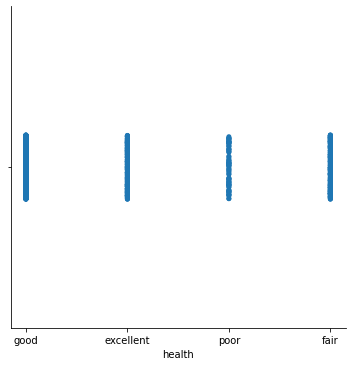

In [31]:
sns.catplot(x='health', data=gssdata)

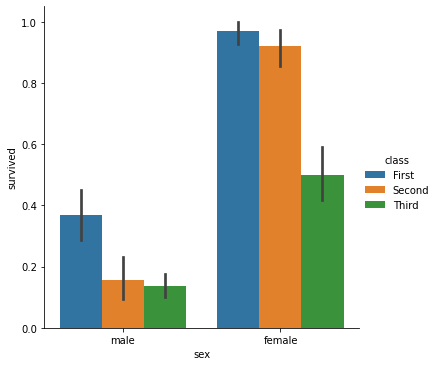

In [35]:
titanic = sns.load_dataset("titanic")
sns.catplot(x="sex", y="survived", hue="class", kind="bar", data=titanic)

**Question**: What classification accuracy could you achieve if you simply predicted `poorhealth` without a model?  What classification accuracy would you get if you were to predict the multi-class `health` variable? Is accuracy the correct metric?

*your answer here*

### Data Cleaning - Basic Handling of Missingness

Let's begin by fitting an unregularized logistic regression model to predict poor health based on all the other predictors in the model and three $k$-NN models with $k=5,10,20$.

First we need to do a small amount of data clean-up.  
1. Determine the amount of missingness in each variable.  If there is *a lot*, we will drop the variable from the predictor set (not quite yet).  If there is a little, we will impute.
2. Drop any variables with lots of missingnes (in a new data set).
3. Do simple imputations for variables with a little bit of missingness.
4. Create dummies for categorical predictors.


In [36]:
#########
# 1. Determine the amount of missingness in each variable. 
# Use is.na() in combination with .sum()
########

# Your code here
gssdata.isna().sum()

id              0
health          0
partyid         0
age             2
sex             0
sexornt         0
educ            2
marital         2
race            0
income        661
poorhealth      0
dtype: int64

In [37]:
#######
# And then build your predictor set
# 2. Drop any variables with lots of missingnes (in a new data set).
# 3. Do simple imputations for variables with a little bit of missingness.
# 4. Create dummies for categorical predictors.
#########
X = gssdata[['partyid','age','sex','sexornt','educ','marital','race','income']]
X = X.drop(columns='income')

In [40]:
X = X.fillna(value={'age': gssdata.age.mean(), 'educ': gssdata.educ.mean()})
X.isna().sum()

partyid    0
age        0
sex        0
sexornt    0
educ       0
marital    2
race       0
dtype: int64

In [41]:
from IPython.core.display import HTML
# display(HTML(gssdata.to_html())) 

,id,health,partyid,age,sex,sexornt,educ,marital,race,income,poorhealth
0,1,good,rep,43.0,male,bisexual/other,14.0,never married,white,NaN,0
1,2,excellent,dem,74.0,female,hetero,10.0,no longer married,white,NaN,0
2,5,excellent,rep,71.0,male,hetero,18.0,no longer married,black,NaN,0
3,6,good,dem,67.0,female,bisexual/other,16.0,no longer married,white,NaN,0
4,7,good,dem,59.0,female,bisexual/other,13.0,no longer married,black,18.75,0
5,8,excellent,rep,43.0,male,hetero,12.0,never married,white,37.50,0
6,11,excellent,rep,59.0,male,bisexual/other,19.0,no longer married,white,120.00,0
7,13,poor,dem,61.0,female,bisexual/other,13.0,no longer married,white,NaN,1
8,14,excellent,dem,44.0,male,hetero,16.0,married,black,100.00,0
9,16,good,other,75.0,female,bisexual/other,12.0,no longer married,white,11.25,0


In [42]:
#create dummies (lots of ways to do it, two ways will be in the solutions
marital_na = gssdata.marital.isna()
display(gssdata.loc[marital_na])
X = pd.get_dummies(X, drop_first=True)
print(X.isna().sum())
display(X.loc[marital_na])
#print(X.shape)

,id,health,partyid,age,sex,sexornt,educ,marital,race,income,poorhealth
25,40,good,other,50.0,female,bisexual/other,12.0,NaN,black,NaN,0
1478,2222,fair,other,65.0,male,bisexual/other,19.0,NaN,white,NaN,0


age                          0
educ                         0
partyid_other                0
partyid_rep                  0
sex_male                     0
sexornt_gay                  0
sexornt_hetero               0
marital_never married        0
marital_no longer married    0
race_other                   0
race_white                   0
dtype: int64


,age,educ,partyid_other,partyid_rep,sex_male,sexornt_gay,sexornt_hetero,marital_never married,marital_no longer married,race_other,race_white
25,50.0,12.0,1,0,0,0,0,0,0,0,0
1478,65.0,19.0,1,0,1,0,0,0,0,0,1


**NOTE**
pd.get_dummies ignores NaN values. As a result, index 25 & 1478 with missing values for marital are encoded as if they are currently married (since both the encoded variables are 0). This is obviously **wrong**, but I will ignore this for now. 

## Part 2:  Fit Basic Models

In this section we ask you to:

1. Split the data into 70-30 train-test splits (use the code provided...should have been done before EDA :( )
2. Fit an unregularize logistic regression model to predict `poorhealth` from all predictors except income.
    
    2b. If you have time: use 'LogisticRegressionCV' to find a well-tuned L2 regularized model.
    
    
3. Fit $k$-NN classification models with $k=1,15,25$ to predict `poorhealth` from all predictors except income.
4. Report classification accuracy on both train and test set for all models.

In [43]:
#######
# Use the following train_test_split code to: 
# 1. Split the data into 70-30 train-test splits
#######
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata.shape[0]), train_size=0.70)

from sklearn.neighbors import KNeighborsClassifier

KNeighborsClassifier

sklearn.neighbors._classification.KNeighborsClassifier

In [ ]:
######
# 2. Fit an unregularize logistic regression model to predict `poorhealth` 
#    from all predictors except income.
# 2b. If you have time: use 'LogisticRegressionCV' to find a well-tuned L2 regularized model.
# 3. Fit $k$-NN classification models with k=1,15,25 to predict `poorhealth` 
#    from all predictors except income.
######

In [46]:
X.shape, gssdata.shape

((1569, 11), (1569, 11))

In [45]:
xtrain, xtest = X.loc[itrain], X.loc[itest]
ytrain, ytest = gssdata.loc[itrain], gssdata.loc[itest]
xtrain.shape, y_train.shape

((1098, 11), (1567,))

In [ ]:
lr1 = LogisticRegression(C=1000000).fit(X, )

In [ ]:
######
# 4. Report classification accuracy on both train and test set for all models.
######


## Part 3: Evaluate Models via Confusion matrices and ROC Curves

In this part we ask that you:
1. Plot the histograms of predicted probabilities for your favorite model from above
2. Create the confusion matrices for (a) the default threshold for classification and (b) a well-chosen threshold for classification to balance errors more equally.
3. Make ROC curves to evaluate a model's overall useability.
4. Use the ROC curves to select a threshold to balance the two types of errors.

As a reminder of Confustion Matrices:
- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](confusionmatrix_360.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [ ]:
#####
# 1. Plot the histograms of predicted probabilities on train for your favorite 
#    model from above
#####

In [ ]:
#####
#  2. Create the confusion matrices for (a) the default threshold for classification and 
#     (b) a well-chosen threshold for classification to balance errors more equally.
#####

from sklearn.metrics import confusion_matrix

# this function may help to manually make confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred


In [ ]:
#####
# 3. Make ROC curves to evaluate a model's overall useability.
#####

from sklearn.metrics import roc_curve, auc

# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")

4. Use the ROC curves to select a threshold to balance the two types of errors.

*your answer here*


## Part 4: Imputation

In this part we ask that you explore the effects of imputation:
1. Plot the histogram of `income`.
2. Create a new variable `income_imp` that imputes the median or mean income for all the missing values and plot the histogram for this new variable.
3. Compare the histograms above.


4. Update your `poorhealth` prediction model(s) by incorporating `income_imp`. 
5. Compare the accuracy of this new model.


And if there is time:
       
6. Create a new variable `income_imp2` that imputes the value via a model.
7. Update your `poorhealth` prediction model(s) by incorporating `income_imp2`. 
8. Compare the accuracy of this newest model.

In [ ]:
#####
# 1. Plot the histogram of `income`.
# 2. Create a new variable `income_imp` that imputes the median or 
#    mean income for all the missing values and plot the histogram for this new variable.
#####

3. Compare the histograms above.

*your answer here*

In [ ]:
#####
# 4. Update your `poorhealth` prediction model(s) by incorporating `income_imp`. 
# 5. Calculate and compare the accuracy of this new model.
# And if there is time:
# 6. Create a new variable `income_imp2` that imputes the value via a model.
# 7. Update your `poorhealth` prediction model(s) by incorporating `income_imp2`. 
# 8. Calculate and compare the accuracy of this newest model.
#####


5 and 8. Compare the accuracies.

*your answer here*